In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from scipy.stats import entropy
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin_min
import gc
import time
import os

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
os.environ["WANDB_DISABLED"] = "true"

In [4]:
!pip install realtabformer transformers==4.24.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 2.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of realtabformer to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 127.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB

In [5]:
from google.colab import drive
import pandas as pd
from realtabformer import REaLTabFormer
from sklearn.utils import resample
import transformers
import re
import traceback

In [6]:
import transformers
print(transformers.__version__)

4.24.0


Prepare July Data

In [34]:
dfaugust = pd.read_csv("df_augustweek2.csv")
dfaugust.head()
dforiginal=dfaugust.copy()

,Date,Duration,Src_Port,Dest_Port,Protocol,TOS,Packets,Bytes,Label,U,A,P,R,S,F
0,2016-08-08 08:24:59,0.000,42998,8194,6,0,1,44,scan44,0,0,0,0,1,0
1,2016-08-08 08:25:21,0.000,64677,3389,6,0,1,44,scan44,0,0,0,0,1,0
2,2016-08-08 00:14:31,0.000,37777,17,17,40,1,28,background,0,1,0,0,0,0
3,2016-08-08 08:24:13,0.000,35796,3306,6,0,1,44,scan44,0,0,0,0,1,0
4,2016-08-08 00:23:21,0.592,25,60939,6,0,5,564,anomaly-spam,0,1,1,0,1,1


In [35]:
def map_classes(label):
    label = label.lower()
    if label.startswith('background'):
        return 0
    elif label.startswith('dos'):
        return 1
    elif label.startswith('nerisbotnet'):
        return 2
    elif label.startswith('scan44'):
        return 3
    elif label.startswith('anomaly-spam'):
        return 4

# Apply the mapping function to the 'Label' column
dfaugust['Class'] = dfaugust['Label'].apply(map_classes)
dfaugust['Class'] = dfaugust['Class'].astype(int)

In [36]:
def map_labels(label):
    label = label.lower()
    if label.startswith('background'):
        return 'Benign'
    elif label.startswith('dos'):
        return 'DoS'
    elif label.startswith('nerisbotnet'):
        return 'Botnet'
    elif label.startswith('scan44'):
        return 'Scan44'
    elif label.startswith('anomaly-spam'):
        return 'Spam'

# Apply the mapping function to the 'Label' column
dfaugust['Label'] = dfaugust['Label'].apply(map_labels)

In [37]:
dfaugust.Label.value_counts()

,count
Label,
Benign,30000
Scan44,17500
Spam,17500
Botnet,17500
DoS,17500


In [38]:
print(dfaugust.columns)

Index(['Date', 'Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS',
       'Packets', 'Bytes', 'Label', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [39]:
dfbefore=dfaugust.copy()

In [40]:
#reduce samples of minority class
spam_reduced_august = dfaugust[dfaugust.Label == "Spam"].sample(n=2000, random_state=42)
botnet_reduced_august = dfaugust[dfaugust.Label== "Botnet"].sample(n=2000, random_state=42)
# dos_reduced_july = dfjuly[dfjuly.Label == "DoS"].sample(n=2000, random_state=42)
# scan44_reduced_july = dfjuly[dfjuly.Label == "Scan44"].sample(n=2000, random_state=42)
dfaugust = dfaugust[~dfaugust.Label.isin(["Spam", "Botnet"])]
dfaugust= pd.concat([spam_reduced_august, botnet_reduced_august, dfaugust])
dfaugust.Label.value_counts()

,count
Label,
Benign,30000
DoS,17500
Scan44,17500
Spam,2000
Botnet,2000


In [41]:
dfaugust.Label.value_counts()

,count
Label,
Benign,30000
DoS,17500
Scan44,17500
Spam,2000
Botnet,2000


In [42]:
dfaugust = dfaugust.drop(columns=['Date', 'Label'])

In [43]:
dfaugust.Class.value_counts()

,count
Class,
0,30000
1,17500
3,17500
4,2000
2,2000


In [44]:
print(dfaugust.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [45]:
dforiginal=dfaugust.copy()

In [46]:
botnet_orig = dfaugust[dfaugust.Class == 2]
spam_orig = dfaugust[dfaugust.Class == 4]


Split Train/Test

In [47]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.metrics import classification_report
# Define MLP classifier
clf_name_mlp = 'MLP'
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100, 100), max_iter=2000, early_stopping=True)

# Define SVM classifier
clf_name_svm = 'SVM'
svm_classifier = SVC(class_weight='balanced', kernel='rbf', C=0.1, probability=True,random_state=42)

In [21]:
print(dfaugust.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [48]:
# fit algorithm to data
def fit_algo(algo, train_x, train_y):

    model = algo.fit(train_x, train_y)
    gc.collect()
    return model

def train_and_test(clf_name, clf, results, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model = fit_algo(clf, X_train, y_train)
    train_time = time.time() - start_time

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    f1 = f1_score(y_test, y_pred, average=None)
    f1_avg = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate FPR and FNR for each class
    class_fpr = []
    class_fnr = []

    for i in range(conf_matrix.shape[0]):
        tn = np.sum(np.delete(np.delete(conf_matrix, i, axis=0), i, axis=1))  # sum of all non-i cells
        fp = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]  # sum of i-th column, excluding diagonal
        fn = np.sum(conf_matrix[i, :]) - conf_matrix[i, i]  # sum of i-th row, excluding diagonal
        tp = conf_matrix[i, i]  # i-th diagonal element

        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0  # Avoid division by zero
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0  # Avoid division by zero

        class_fpr.append(fpr)
        class_fnr.append(fnr)

    # Overall FPR and FNR (averaging across classes)
    avg_fpr = np.mean(class_fpr)
    avg_fnr = np.mean(class_fnr)

    return f1, f1_avg, train_time, conf_matrix, class_fpr, class_fnr, avg_fpr, avg_fnr

def preprocess_data(df):
    df_copy = df.copy()

    X = df_copy.drop('Class', axis=1)
    y = df_copy['Class']

    X = X.apply(pd.to_numeric, errors='coerce')

    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(X.mean(), inplace=True)

    # Double-check that no NaN values remain
    if X.isnull().any().any():
        print("Warning: NaNs detected in data after preprocessing. Check data sources or methods.")
        X.fillna(0, inplace=True)  # Fallback option: replace any remaining NaNs with 0

    return X.values, y.values

# Preprocess data
X_august, y_august = preprocess_data(dfaugust)


In [49]:
print(dfbefore.Class.value_counts())

Class
0    30000
3    17500
4    17500
2    17500
1    17500
Name: count, dtype: int64


In [50]:
dfbefore.columns

Index(['Date', 'Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS',
       'Packets', 'Bytes', 'Label', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')

BEFORE

In [25]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

X = dfaugust.drop(columns=['Class'])
y = dfaugust['Class']

# Map the labels to classes
class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
mlp_classifier.fit(X_train, y_train)
y_pred_mlp = mlp_classifier.predict(X_test)

# F1 score
f1_mlp = f1_score(y_test, y_pred_mlp, average=None)
print("=== MLP Classification Report ===")
print(classification_report(y_test, y_pred_mlp, target_names=[class_labels[i] for i in class_labels]))

# F1 scores per class with class names
print("F1 scores per class:")
for i, f1 in enumerate(f1_mlp):
    print(f"Class {class_labels[i]}: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_mlp)
print("\nConfusion Matrix:")
print(pd.DataFrame(conf_matrix, index=[class_labels[i] for i in class_labels], columns=[class_labels[i] for i in class_labels]))

# Calculate FPR and FNR manually per class
fpr_dict = {}
fnr_dict = {}
for i in range(len(conf_matrix)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    fnr_dict[class_labels[i]] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[class_labels[i]] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {k}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {k}: {v:.4f}")

# PRAUC (Precision-Recall AUC)
y_prob = mlp_classifier.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=list(class_labels.values()))

# PRAUC per class
prauc_dict = {}
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100), max_iter=2000)

=== MLP Classification Report ===
              precision    recall  f1-score   support

      Benign       0.82      0.95      0.88      9000
         DoS       0.94      0.94      0.94      5250
      Botnet       0.00      0.00      0.00       600
        Scan       0.95      0.90      0.92      5250
        Spam       0.00      0.00      0.00       600

    accuracy                           0.88     20700
   macro avg       0.54      0.56      0.55     20700
weighted avg       0.83      0.88      0.85     20700

F1 scores per class:
Class Benign: 0.8806
Class DoS: 0.9379
Class Botnet: 0.0000
Class Scan: 0.9230
Class Spam: 0.0000

Confusion Matrix:
        Benign   DoS  Botnet  Scan  Spam
Benign    8577   161       0   262     0
DoS        336  4914       0     0     0
Botnet     598     0       0     2     0
Scan       370   154       0  4726     0
Spam       600     0       0     0     0

False Negative Rate (FNR) per class:
Class Benign: 0.0470
Class DoS: 0.0640
Class Botnet: 1.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [26]:
dfaugust.head()


,Duration,Src_Port,Dest_Port,Protocol,TOS,Packets,Bytes,U,A,P,R,S,F,Class
8202,0.436,25,40899,6,0,5,564,0,1,1,0,1,1,4
43222,0.552,58547,25,6,0,6,441,0,1,1,1,1,0,4
28466,4.236,46472,25,6,0,12,867,0,1,1,1,1,0,4
57772,0.728,38620,25,6,0,6,446,0,1,1,1,1,0,4
15597,0.412,25,35350,6,0,5,564,0,1,1,0,1,1,4


In [27]:
from realtabformer import REaLTabFormer
import traceback

In [51]:
dfbotnet = dfbefore[dfbefore.Class == 2]
dfspam = dfbefore[dfbefore.Class == 4]

In [52]:
dfbotnet.shape
dfspam.shape

(17500, 16)

(17500, 16)

In [53]:
dfbotnet.columns
dfspam.columns

Index(['Date', 'Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS',
       'Packets', 'Bytes', 'Label', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')

Index(['Date', 'Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS',
       'Packets', 'Bytes', 'Label', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')

In [54]:
import psutil, os
import torch


In [33]:
# Function to generate synthetic data
import threading
import psutil
import os
import time
import subprocess

def monitor_gpu(interval=5, duration=30):
    print("Live GPU Monitoring Started...\n")
    for _ in range(int(duration / interval)):
        output = subprocess.getoutput('nvidia-smi')
        print(output)
        print("-" * 80)
        time.sleep(interval)

def log_gpu_memory(tag):
    if torch.cuda.is_available():
      print(f"[{tag}] GPU: {torch.cuda.get_device_name(0)}")
      print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
      print(f"Memory Reserved : {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
      try:
          output = subprocess.check_output(
              ["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,nounits,noheader"],
              encoding="utf-8"
          )
          util_percent = output.strip().split('\n')[0]
          print(f"GPU Utilization : {util_percent}%")
      except Exception as e:
          print(f"Could not fetch GPU utilization: {e}")

def generate_synthetic_botnet(df, multiplier):
  process = psutil.Process(os.getpid())

  # Start monitoring in a separate thread
  gpu_thread = threading.Thread(target=monitor_gpu, args=(5,30), daemon=True)
  gpu_thread.start()

  classes_to_keep = [2]
  filtered_df = df[df['Class'].isin(classes_to_keep)]
  filtered_df.Class.value_counts()
  n_samples = len(filtered_df) * multiplier

  #start time
  start_time = time.time()
  train_start_ram = process.memory_info().rss / 1024**2
  # Initialize REaLTabFormer model
  rtf_model = REaLTabFormer(
    model_type="tabular",
    gradient_accumulation_steps=4,
    epochs=3,
    logging_steps=100,
    numeric_max_len=12
  )

  # Fit the model on the filtered dataset
  rtf_model.fit(filtered_df)

  #end time
  end_time = time.time()
  train_end_ram = process.memory_info().rss / 1024**2
  print(f"Training Time for botnet class: {(end_time - start_time):.2f} seconds")
  print(f"RAM Usage after training for botnet class: {train_end_ram - train_start_ram:.2f} MB")
  print(f"CPU Usage for training: {psutil.cpu_percent(interval=1)}%")
  log_gpu_memory("Training")

  #Generation
  df['Class'] = df['Class'].astype(str)
  gen_start = time.time()
  gen_start_ram = process.memory_info().rss / 1024**2

  samples = rtf_model.sample(n_samples=n_samples)
  gen_end = time.time()
  gen_end_ram = process.memory_info().rss / 1024**2

  print(f"Generation Time for botnet: {gen_end - gen_start:.2f} seconds")
  print(f"RAM Usage for generation botnet: {gen_end_ram - gen_start_ram:.2f} MB")
  print(f"CPU Usage for generation: {psutil.cpu_percent(interval=1)}%")
  log_gpu_memory("Generation")
  return samples

synthetic_samples_botnet = generate_synthetic_botnet(dfbefore, 3)
X_synthetic = synthetic_samples_botnet.drop(columns=['Class']).values
y_synthetic = synthetic_samples_botnet['Class'].values


# Save CSV files
synthetic_samples_botnet.to_csv('Reverse_LLM_Generated_Botnet_August.csv', index=False)

print("Synthetic samples saved successfully!")

Live GPU Monitoring Started...

Computing the sensitivity threshold...
Using parallel computation!!!


Bootstrap round:   0%|          | 0/500 [00:00<?, ?it/s]

Mon May 26 07:26:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             45W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Map:   0%|          | 0/17500 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using cuda_amp half precision backend
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:585: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
***** Running training *****
  Num examples = 17500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 1641
  Number of trainable parameters = 43620096
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2473: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(dtyp

Step,Training Loss
100,0.712200
200,0.459600
300,0.448000
400,0.441000
500,0.433100
600,0.427300
700,0.427400
800,0.424000
900,0.422900
1000,0.422300


Saving model checkpoint to rtf_checkpoints/checkpoint-100
Configuration saved in rtf_checkpoints/checkpoint-100/config.json
Model weights saved in rtf_checkpoints/checkpoint-100/pytorch_model.bin
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2473: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(dtype=self.amp_dtype)
Saving model checkpoint to rtf_checkpoints/checkpoint-200
Configuration saved in rtf_checkpoints/checkpoint-200/config.json
Model weights saved in rtf_checkpoints/checkpoint-200/pytorch_model.bin
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2473: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(dtype=self.amp_dtype)
Saving model checkpoint to rtf_checkpoints/checkpoint-300
Configuration saved in rtf_checkpoints/checkpoint-300/conf

  0%|          | 0/8661 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 8704 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to rtf_checkpoints/best-disc-model
Configuration saved in rtf_checkpoints/best-disc-model/config.json
Model weights saved in rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to rtf_checkpoints/mean-best-disc-model
Configuration saved in rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
Saving model checkpoint to rtf_checkpoints/last-epoch-model
Configuration saved in rtf_checkpoints/last-epoch-model/config.json


Critic round: 5,                     sensitivity_threshold: 0.0035186389322264524,                         val_sensitivity: 0.0009969228833184012,                             val_sensitivities: [np.float64(0.000547627294769657), np.float64(0.004673016972635954), np.float64(0.0027575337720817457), np.float64(0.0030332525112573604), np.float64(0.0017509525458953932), np.float64(-0.002364738482854174), np.float64(-0.0011454797367509526), np.float64(-0.0019047454104606863), np.float64(-0.0030491860062348457), np.float64(-0.0009521995150675444), np.float64(0.0013588500173190162), np.float64(0.0005175280587501734), np.float64(0.0015216487703498438), np.float64(0.005068588055978939), np.float64(0.0031411944021061387)]


Model weights saved in rtf_checkpoints/last-epoch-model/pytorch_model.bin
loading configuration file rtf_checkpoints/best-disc-model/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "use_cache": true,
  "vocab_size": 397
}

loading weights file rtf_checkpoints/best-disc-model/pytorch_model.bin
All model checkpoin

Training Time for botnet class: 482.67 seconds
RAM Usage after training for botnet class: 1585.26 MB
CPU Usage for training: 5.1%
[Training] GPU: NVIDIA A100-SXM4-40GB
Memory Allocated: 350.31 MB
Memory Reserved : 672.00 MB
GPU Utilization : 0%


  0%|          | 0/52500 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 52608 samples generated. Sampling efficiency is: 100.0000%
Generation Time for botnet: 298.45 seconds
RAM Usage for generation botnet: -58.09 MB
CPU Usage for generation: 4.3%
[Generation] GPU: NVIDIA A100-SXM4-40GB
Memory Allocated: 526.14 MB
Memory Reserved : 1156.00 MB
GPU Utilization : 0%
Synthetic samples saved successfully!


In [55]:
# Function to generate synthetic data
import threading
import psutil
import os
import time
import subprocess

def monitor_gpu(interval=5, duration=30):
    print("Live GPU Monitoring Started...\n")
    for _ in range(int(duration / interval)):
        output = subprocess.getoutput('nvidia-smi')
        print(output)
        print("-" * 80)
        time.sleep(interval)

def log_gpu_memory(tag):
    if torch.cuda.is_available():
      print(f"[{tag}] GPU: {torch.cuda.get_device_name(0)}")
      print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")
      print(f"Memory Reserved : {torch.cuda.memory_reserved(0)/1024**2:.2f} MB")
      try:
          output = subprocess.check_output(
              ["nvidia-smi", "--query-gpu=utilization.gpu", "--format=csv,nounits,noheader"],
              encoding="utf-8"
          )
          util_percent = output.strip().split('\n')[0]
          print(f"GPU Utilization : {util_percent}%")
      except Exception as e:
          print(f"Could not fetch GPU utilization: {e}")

def generate_synthetic_spam(df, multiplier):
  process = psutil.Process(os.getpid())

  # Start monitoring in a separate thread
  gpu_thread = threading.Thread(target=monitor_gpu, args=(5,30), daemon=True)
  gpu_thread.start()

  classes_to_keep = [4]
  filtered_df = df[df['Class'].isin(classes_to_keep)]
  filtered_df.Class.value_counts()
  n_samples = len(filtered_df) * multiplier

  #start time
  start_time = time.time()
  train_start_ram = process.memory_info().rss / 1024**2
  # Initialize REaLTabFormer model
  rtf_model = REaLTabFormer(
    model_type="tabular",
    gradient_accumulation_steps=4,
    epochs=3,
    logging_steps=100,
    numeric_max_len=12
  )

  # Fit the model on the filtered dataset
  rtf_model.fit(filtered_df)

  #end time
  end_time = time.time()
  train_end_ram = process.memory_info().rss / 1024**2
  print(f"Training Time for spam class: {(end_time - start_time):.2f} seconds")
  print(f"RAM Usage after training for spam class: {train_end_ram - train_start_ram:.2f} MB")
  print(f"CPU Usage for training: {psutil.cpu_percent(interval=1)}%")
  log_gpu_memory("Training")

  #Generation
  df['Class'] = df['Class'].astype(str)
  gen_start = time.time()
  gen_start_ram = process.memory_info().rss / 1024**2

  samples = rtf_model.sample(n_samples=n_samples)
  gen_end = time.time()
  gen_end_ram = process.memory_info().rss / 1024**2

  print(f"Generation Time for spam: {gen_end - gen_start:.2f} seconds")
  print(f"RAM Usage for generation spam: {gen_end_ram - gen_start_ram:.2f} MB")
  print(f"CPU Usage for generation: {psutil.cpu_percent(interval=1)}%")
  log_gpu_memory("Generation")
  return samples

synthetic_samples_spam = generate_synthetic_spam(dfbefore, 3)
X_synthetic_spam = synthetic_samples_spam.drop(columns=['Class']).values
y_synthetic_spam = synthetic_samples_spam['Class'].values


# Save CSV files
synthetic_samples_spam.to_csv('Reverse_LLM_Generated_Spam_August.csv', index=False)

print("Synthetic samples saved successfully!")

Live GPU Monitoring Started...

Computing the sensitivity threshold...
Using parallel computation!!!


/usr/local/lib/python3.11/dist-packages/realtabformer/realtabformer.py:570: UserWarning: Duplicate rate (0.0) in the data is zero. The `qt_interval` will be set                     to qt_interval_unique=100.
  warnings.warn(


Bootstrap round:   0%|          | 0/500 [00:00<?, ?it/s]

Mon May 26 07:41:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   29C    P0             51W /  400W |    1681MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

Map:   0%|          | 0/17500 [00:00<?, ? examples/s]

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using cuda_amp half precision backend
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:585: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
***** Running training *****
  Num examples = 17500
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total op

Step,Training Loss
100,1.147100
200,0.714700
300,0.685500
400,0.671500
500,0.668000
600,0.658000
700,0.655100
800,0.651200
900,0.651300
1000,0.648700


Saving model checkpoint to rtf_checkpoints/checkpoint-100
Configuration saved in rtf_checkpoints/checkpoint-100/config.json
Model weights saved in rtf_checkpoints/checkpoint-100/pytorch_model.bin
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2473: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(dtype=self.amp_dtype)
Saving model checkpoint to rtf_checkpoints/checkpoint-200
Configuration saved in rtf_checkpoints/checkpoint-200/config.json
Model weights saved in rtf_checkpoints/checkpoint-200/pytorch_model.bin
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:2473: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  else torch.cuda.amp.autocast(dtype=self.amp_dtype)
Saving model checkpoint to rtf_checkpoints/checkpoint-300
Configuration saved in rtf_checkpoints/checkpoint-300/conf

  0%|          | 0/8661 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 8704 samples generated. Sampling efficiency is: 100.0000%


Saving model checkpoint to rtf_checkpoints/best-disc-model
Configuration saved in rtf_checkpoints/best-disc-model/config.json
Model weights saved in rtf_checkpoints/best-disc-model/pytorch_model.bin
Saving model checkpoint to rtf_checkpoints/mean-best-disc-model
Configuration saved in rtf_checkpoints/mean-best-disc-model/config.json
Model weights saved in rtf_checkpoints/mean-best-disc-model/pytorch_model.bin
Saving model checkpoint to rtf_checkpoints/last-epoch-model
Configuration saved in rtf_checkpoints/last-epoch-model/config.json


Critic round: 5,                     sensitivity_threshold: 0.003593661240041564,                         val_sensitivity: -0.018772174113843666,                             val_sensitivities: [np.float64(-0.017799445791479046), np.float64(-0.017747488742639417), np.float64(-0.017299965361967443), np.float64(-0.01667370973328715), np.float64(-0.018630065812261863), np.float64(-0.019963630065812265), np.float64(-0.01984031866989955), np.float64(-0.019916522341531004), np.float64(-0.020131278143401453), np.float64(-0.019399722895739522), np.float64(-0.01836404572220298), np.float64(-0.019103221337028062), np.float64(-0.019535503983373743), np.float64(-0.01804676134395566), np.float64(-0.019130931763075853)]


Model weights saved in rtf_checkpoints/last-epoch-model/pytorch_model.bin
loading configuration file rtf_checkpoints/best-disc-model/config.json
Model config GPT2Config {
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 5,
  "embd_pdrop": 0.1,
  "eos_token_id": 6,
  "initializer_range": 0.02,
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 6,
  "n_positions": 1024,
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "torch_dtype": "float32",
  "transformers_version": "4.24.0",
  "use_cache": true,
  "vocab_size": 1488
}

loading weights file rtf_checkpoints/best-disc-model/pytorch_model.bin
All model checkpoi

Training Time for spam class: 920.43 seconds
RAM Usage after training for spam class: 175.03 MB
CPU Usage for training: 0.6%
[Training] GPU: NVIDIA A100-SXM4-40GB
Memory Allocated: 195.32 MB
Memory Reserved : 742.00 MB
GPU Utilization : 0%


  0%|          | 0/52500 [00:00<?, ?it/s]

Generated 0 invalid samples out of total 52608 samples generated. Sampling efficiency is: 100.0000%
Generation Time for spam: 307.91 seconds
RAM Usage for generation spam: -127.42 MB
CPU Usage for generation: 0.5%
[Generation] GPU: NVIDIA A100-SXM4-40GB
Memory Allocated: 195.80 MB
Memory Reserved : 994.00 MB
GPU Utilization : 0%
Synthetic samples saved successfully!


In [56]:
botnet_gen = pd.read_csv("/content/Reverse_LLM_Generated_Botnet_August.csv")
spam_gen = pd.read_csv("/content/Reverse_LLM_Generated_Spam_August.csv")

In [57]:
botnet_gen.drop(columns=['Date', 'Label'], inplace=True)
spam_gen.drop(columns=['Date', 'Label'], inplace=True)

In [58]:
print(botnet_gen.columns)
print(spam_gen.columns)

Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')
Index(['Duration', 'Src_Port', 'Dest_Port', 'Protocol', 'TOS', 'Packets',
       'Bytes', 'U', 'A', 'P', 'R', 'S', 'F', 'Class'],
      dtype='object')


In [59]:
print(botnet_gen.shape)
print(spam_gen.shape)

(52500, 14)
(52500, 14)


JSD (Low is better)

In [60]:
from scipy.spatial.distance import jensenshannon
selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']

# average JSD over selected features only
def average_jsd(df1, df2, features, bins=50):
    jsd_values = []
    for feature in features:
        p = np.histogram(df1[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        q = np.histogram(df2[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        p += 1e-8
        q += 1e-8
        jsd = jensenshannon(p, q)**2 #actual JSD value
        jsd_values.append(jsd)

    avg_jsd = np.mean(jsd_values)
    return avg_jsd

avg_jsd_botnet = average_jsd(botnet_orig, botnet_gen, selected_features)
avg_jsd_spam = average_jsd(spam_orig, spam_gen, selected_features)

print("Average JSD (Botnet):", avg_jsd_botnet)
print("Average JSD (Spam):", avg_jsd_spam)

Average JSD (Botnet): 0.003044396655282042
Average JSD (Spam): 0.0021361597348385523


feature-wise

In [61]:
from scipy.spatial.distance import jensenshannon
import numpy as np
#feature-wise
def jsd_per_feature(df1, df2, features, bins=50):
    jsd_dict = {}
    for feature in features:
        p = np.histogram(df1[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        q = np.histogram(df2[feature], bins=bins, range=(df1[feature].min(), df1[feature].max()), density=True)[0]
        p += 1e-8
        q += 1e-8
        jsd = jensenshannon(p, q)**2  #actual JSD value
        jsd_dict[feature] = jsd
    return jsd_dict

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']

jsd_botnet = jsd_per_feature(botnet_orig, botnet_gen, selected_features)
jsd_spam = jsd_per_feature(spam_orig, spam_gen, selected_features)

print("JSD per feature (Botnet):")
for feature, jsd in jsd_botnet.items():
    print(f"{feature}: {jsd:.4f}")

print("\nJSD per feature (Spam):")
for feature, jsd in jsd_spam.items():
    print(f"{feature}: {jsd:.4f}")

JSD per feature (Botnet):
Packets: 0.0024
Duration: 0.0035
Bytes: 0.0027
Src_Port: 0.0036
Dest_Port: 0.0031

JSD per feature (Spam):
Packets: 0.0020
Duration: 0.0029
Bytes: 0.0023
Src_Port: 0.0016
Dest_Port: 0.0018


CDF

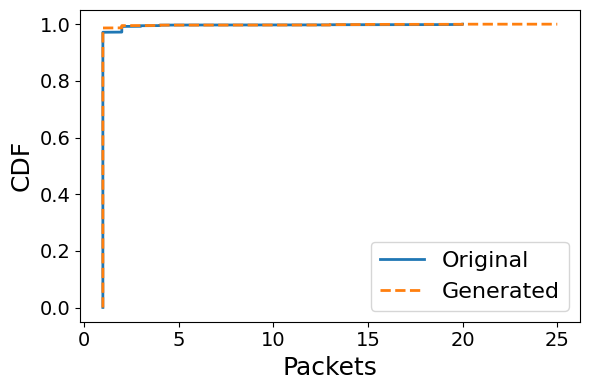

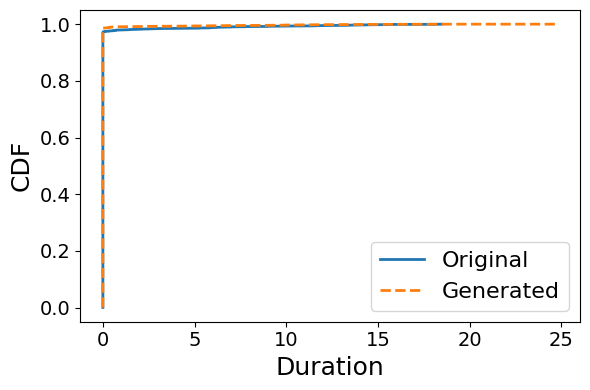

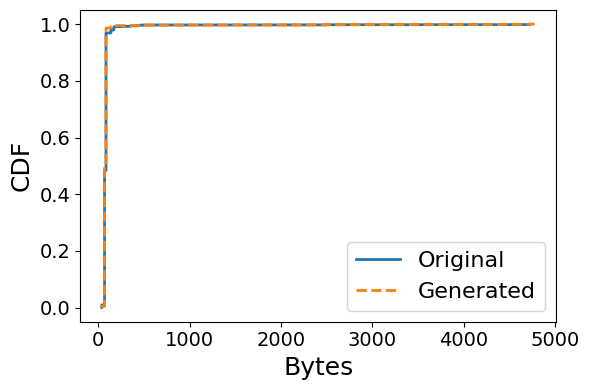

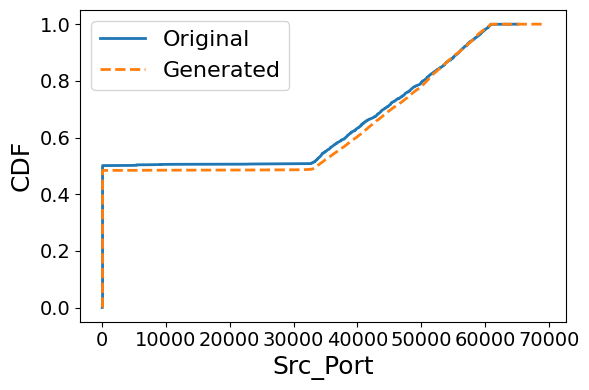

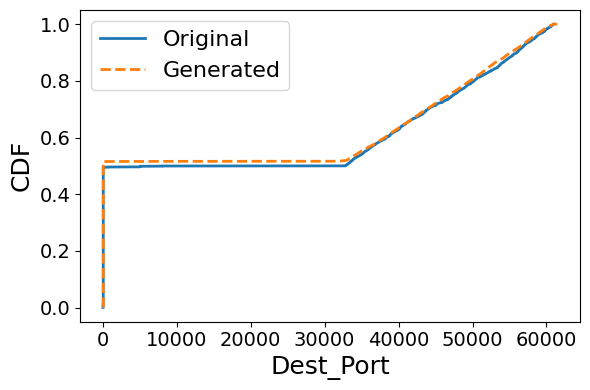

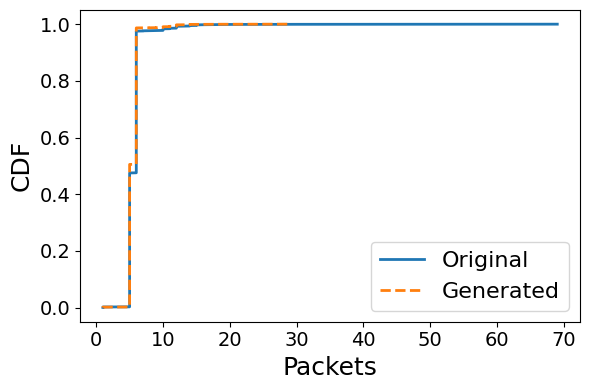

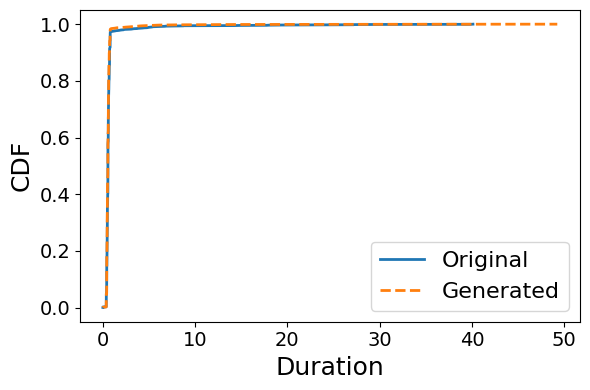

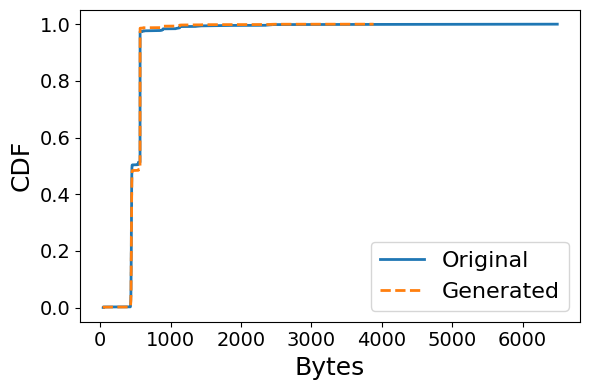

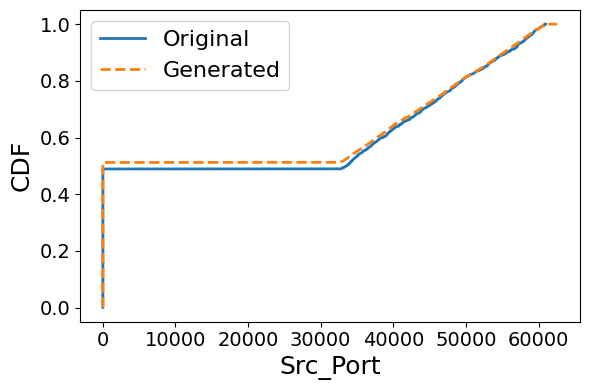

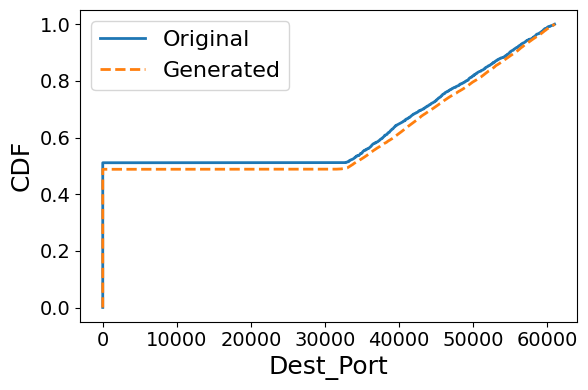

In [62]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cdfs(original_df, generated_df, features):
    for feature in features:
        orig_values = np.sort(original_df[feature].dropna())
        gen_values = np.sort(generated_df[feature].dropna())

        # Compute CDFs
        orig_cdf = np.arange(1, len(orig_values)+1) / len(orig_values)
        gen_cdf = np.arange(1, len(gen_values)+1) / len(gen_values)

        # Plot
        plt.figure(figsize=(6, 4))
        plt.plot(orig_values, orig_cdf, label='Original', linewidth=2)
        plt.plot(gen_values, gen_cdf, label='Generated', linewidth=2, linestyle='--')
        plt.xlabel(feature, fontsize=18)
        plt.ylabel("CDF",fontsize=18)
        plt.legend()
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.legend(fontsize=16)

        plt.tight_layout()
        plt.show()
plot_cdfs(botnet_orig, botnet_gen, selected_features)
plot_cdfs(spam_orig, spam_gen, selected_features)

W2 distance

In [63]:
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import wasserstein_distance
def compute_scaled_wasserstein_distances(df1, df2, features):
    scaler = MinMaxScaler()
    distances = {}

    for feature in features:

        combined = pd.concat([df1[feature], df2[feature]]).values.reshape(-1, 1)
        scaled = scaler.fit_transform(combined).flatten()

        split = len(df1[feature])
        scaled1 = scaled[:split]
        scaled2 = scaled[split:]

        distances[feature] = wasserstein_distance(scaled1, scaled2)

    return distances

w_scaled_botnet = compute_scaled_wasserstein_distances(botnet_orig, botnet_gen, selected_features)
w_scaled_spam = compute_scaled_wasserstein_distances(spam_orig, spam_gen, selected_features)

print("Wasserstein distances (Botnet):")
for k, v in w_scaled_botnet.items():
    print(f"{k}: {v:.4f}")

print("\nWasserstein distances (Spam):")
for k, v in w_scaled_spam.items():
    print(f"{k}: {v:.4f}")

Wasserstein distances (Botnet):
Packets: 0.0011
Duration: 0.0037
Bytes: 0.0008
Src_Port: 0.0160
Dest_Port: 0.0133

Wasserstein distances (Spam):
Packets: 0.0021
Duration: 0.0028
Bytes: 0.0027
Src_Port: 0.0163
Dest_Port: 0.0213


Violin plot

<ipython-input-64-284afa9d3a2c>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Type', y='Value', data=df_combined, palette='Set2')


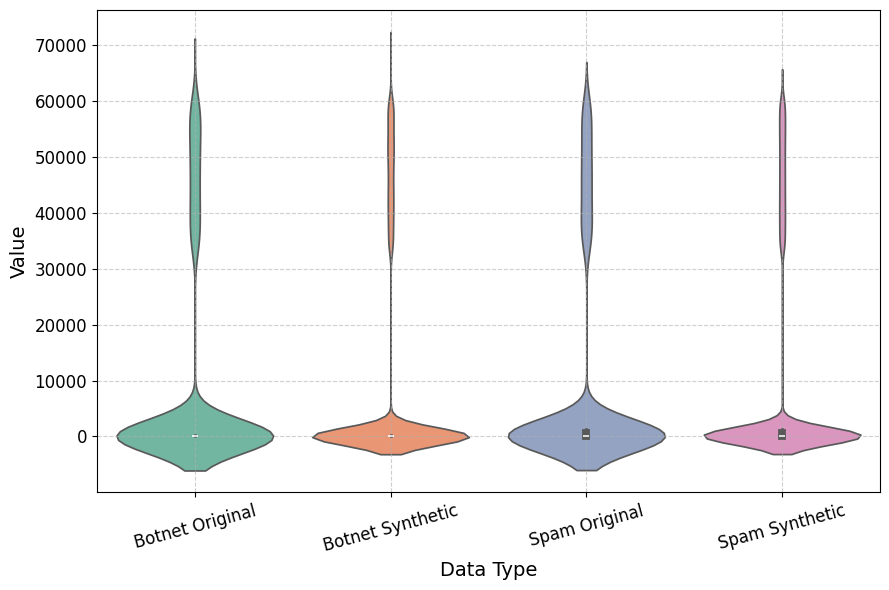

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def combined_violin_plot(botnet_orig, botnet_gen, spam_orig, spam_gen, features):
    data = []
    labels = []
    for label, df in zip(
        ['Botnet Original', 'Botnet Synthetic', 'Spam Original', 'Spam Synthetic'],
        [botnet_orig, botnet_gen, spam_orig, spam_gen]
    ):
        for feature in features:
            data.extend(df[feature].dropna().values)
            labels.extend([label] * df[feature].dropna().shape[0])
    df_combined = pd.DataFrame({'Value': data, 'Type': labels})
    plt.figure(figsize=(9, 6))
    sns.violinplot(x='Type', y='Value', data=df_combined, palette='Set2')
    plt.ylabel("Value", fontsize=14)
    plt.xlabel("Data Type", fontsize=14)
    plt.xticks(rotation=15, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

selected_features = ['Packets', 'Duration', 'Bytes', 'Src_Port', 'Dest_Port']
combined_violin_plot(botnet_orig, botnet_gen, spam_orig, spam_gen, selected_features)


Heatmap

Plotting Spam - Non-Augmented Data Heatmap


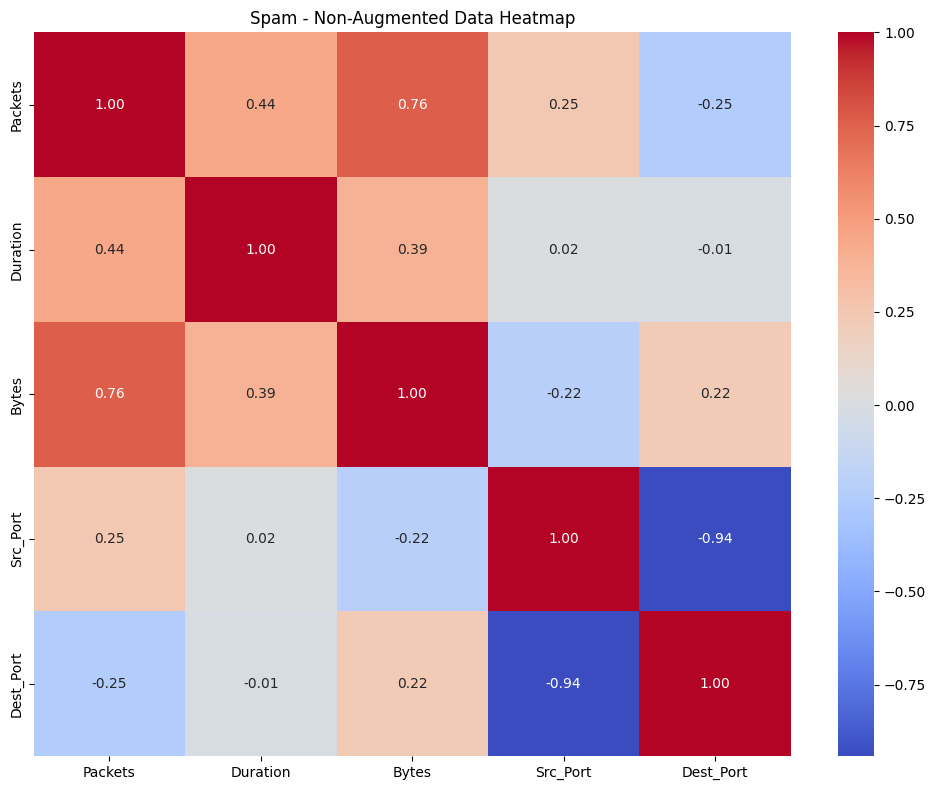

Plotting Spam - Augmented Data Heatmap


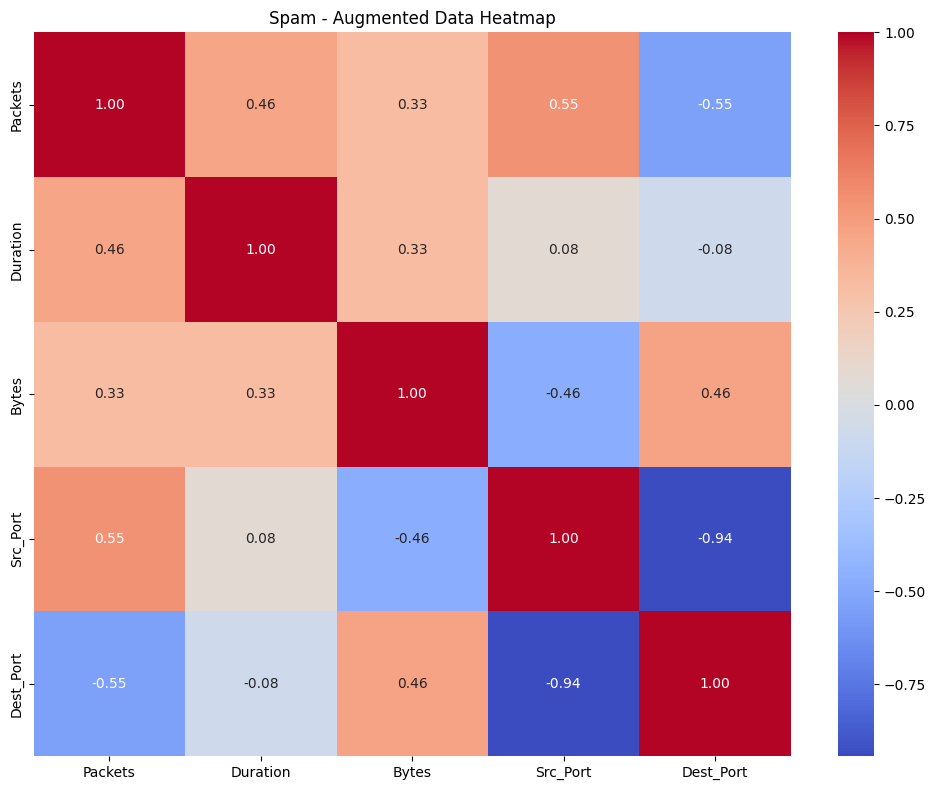

Plotting Botnet - Non-Augmented Data Heatmap


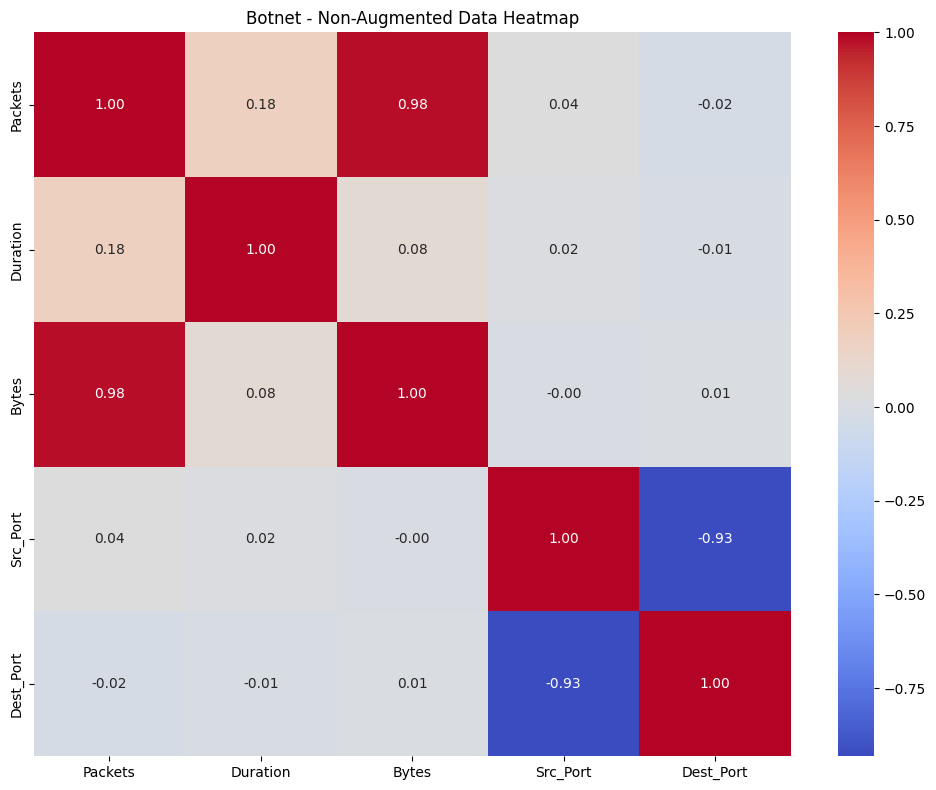

Plotting Botnet - Augmented Data Heatmap


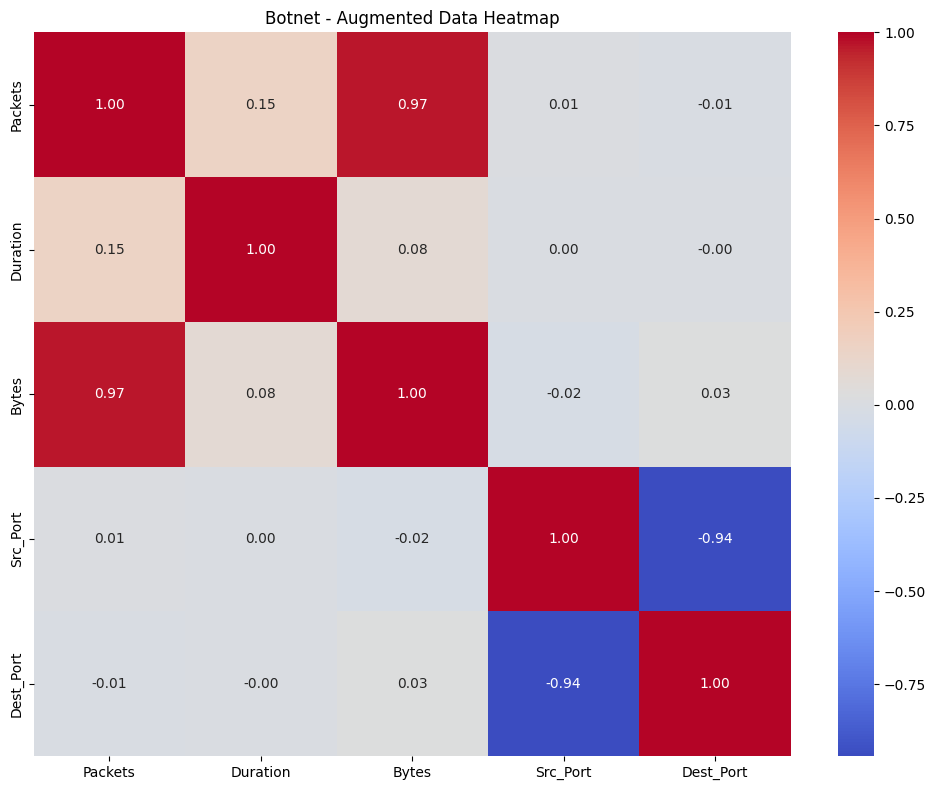

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_heatmap(data, title):
    plt.figure(figsize=(10, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()


print("Plotting Spam - Non-Augmented Data Heatmap")
plot_heatmap(spam_orig[selected_features], 'Spam - Non-Augmented Data Heatmap')
print("Plotting Spam - Augmented Data Heatmap")
plot_heatmap(spam_gen[selected_features], 'Spam - Augmented Data Heatmap')
print("Plotting Botnet - Non-Augmented Data Heatmap")
plot_heatmap(botnet_orig[selected_features], 'Botnet - Non-Augmented Data Heatmap')
print("Plotting Botnet - Augmented Data Heatmap")
plot_heatmap(botnet_gen[selected_features], 'Botnet - Augmented Data Heatmap')


pMSE

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import pandas as pd
import numpy as np

def compute_pmse(original_df, synthetic_df, features=None, test_size=0.3, random_state=42):
    if features is None:
        features = list(set(original_df.columns) & set(synthetic_df.columns))
        features = [f for f in features if pd.api.types.is_numeric_dtype(original_df[f])]

    original_df = original_df[features].copy()
    synthetic_df = synthetic_df[features].copy()
    original_df['label'] = 0
    synthetic_df['label'] = 1
    combined = pd.concat([original_df, synthetic_df], axis=0).sample(frac=1, random_state=random_state).reset_index(drop=True)
    X = combined[features]
    y = combined['label']
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Logistic regression Classifier
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    p_hat = clf.predict_proba(X_test)[:, 1]
    # pMSE Computation
    pmse = np.mean((p_hat - 0.5) ** 2)
    return pmse

pmse_botnet = compute_pmse(botnet_orig, botnet_gen)
pmse_spam = compute_pmse(spam_orig, spam_gen)

print(f"pMSE Botnet: {pmse_botnet:.4f}")
print(f"pMSE Spam: {pmse_spam:.4f}")


pMSE Botnet: 0.2144
pMSE Spam: 0.2145


Similarity calculation

Mahalanobis distance

       Duration  Src_Port  Dest_Port  Protocol  TOS  Packets  Bytes  U  A  P  \
0           0.0     50471         53        17    0        1     70  0  1  0   
1           0.0     50197         53        17    0        1     70  0  1  0   
2           0.0     50718         53        17    0        1     70  0  1  0   
3           0.0        53      49579        17    0        1     86  0  1  0   
4           0.0     59711         53        17    0        1     70  0  1  0   
...         ...       ...        ...       ...  ...      ...    ... .. .. ..   
52493       0.0        53      47225        17    0        1     86  0  1  0   
52494       0.0        53      56813        17    0        1     86  0  1  0   
52497       0.0     39813         53        17    0        1     70  0  1  0   
52498       0.0     33661         53        17    0        1     70  0  1  0   
52499       0.0     33795         53        17    0        1     70  0  1  0   

       R  S  F  Class  
0      0  0  0 

(array([5.1545e+04, 2.2100e+02, 1.6200e+02, 2.0800e+02, 2.4000e+01,
        9.0000e+01, 5.1000e+01, 1.5000e+01, 1.0000e+01, 8.7000e+01,
        4.0000e+00, 1.0000e+00, 8.0000e+00, 0.0000e+00, 3.0000e+00,
        3.0000e+01, 6.0000e+00, 0.0000e+00, 4.0000e+00, 4.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 3.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 3.0000e+00,
        2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  0.78942131,   3.96268496,   7.1359486 ,  10.30921225,
         13.48247589,  16.65573953,  19.82900318,  23.00226682,
         26.17553047,  29.34879411,  32.52205775,  35.6953214 ,
         38.86858504,  42.04184869,  45.21511233,  48.38837598,
         51.56163962,  54.73490326,  57.90816691,  61.08143055

Text(0.5, 1.0, 'Mahalanobis Distance of Synthetic Samples')

Text(0.5, 0, 'Distance')

Text(0, 0.5, 'Frequency')

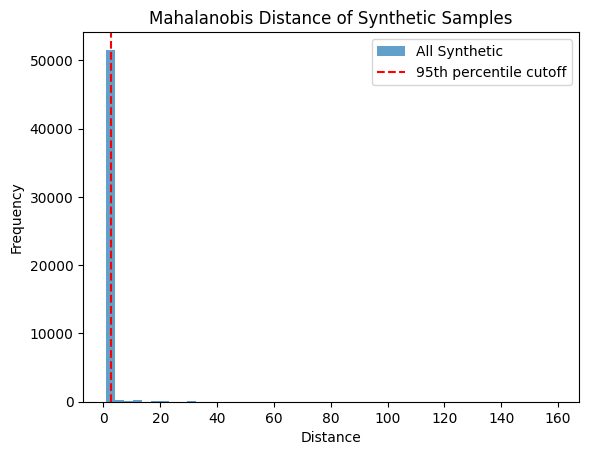

In [67]:
from scipy.spatial import distance
import numpy as np

from sklearn.preprocessing import StandardScaler

#scale
scaler = StandardScaler()
X_real_botnet_scaled = scaler.fit_transform(botnet_orig)
X_synth_botnet_scaled = scaler.transform(botnet_gen)

X_real_spam_scaled = scaler.fit_transform(spam_orig)
X_synth_spam_scaled = scaler.transform(spam_gen)

#botnet
mu = np.mean(X_real_botnet_scaled, axis=0)
cov = np.cov(X_real_botnet_scaled, rowvar=False)
inv_covmat = np.linalg.pinv(cov)

distances = [distance.mahalanobis(x, mu, inv_covmat) for x in X_synth_botnet_scaled]

#spam
mu = np.mean(X_real_spam_scaled, axis=0)
cov = np.cov(X_real_spam_scaled, rowvar=False)
inv_covmat = np.linalg.pinv(cov)

distances_spam = [distance.mahalanobis(x, mu, inv_covmat) for x in X_synth_spam_scaled]

threshold = np.percentile(distances, 95)
filtered_X_botnet_synth = botnet_gen[np.array(distances) < threshold]

threshold = np.percentile(distances_spam, 95)
filtered_X_spam_synth = spam_gen[np.array(distances_spam) < threshold]
print(filtered_X_botnet_synth)
print("Original synthetic samples botnet:", len(X_synth_botnet_scaled))
print("After filtering:", filtered_X_botnet_synth.shape[0])
print("Removed samples:", len(X_synth_botnet_scaled) - filtered_X_botnet_synth.shape[0])

print("Original synthetic samples spam:", len(X_synth_spam_scaled))
print("After filtering:", filtered_X_spam_synth.shape[0])
print("Removed samples:", len(X_synth_spam_scaled) - filtered_X_spam_synth.shape[0])


import matplotlib.pyplot as plt

plt.hist(distances, bins=50, alpha=0.7, label='All Synthetic')
plt.axvline(threshold, color='red', linestyle='--', label='95th percentile cutoff')
plt.title("Mahalanobis Distance of Synthetic Samples")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [68]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np


X = dfaugust.drop(columns=['Class'])
y = dfaugust['Class']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)


filtered_X_botnet_synth = filtered_X_botnet_synth.drop(columns='Class', errors='ignore')
filtered_X_spam_synth = filtered_X_spam_synth.drop(columns='Class', errors='ignore')

# augment synthetic samples
X_train = pd.concat([X_train_orig, filtered_X_botnet_synth, filtered_X_spam_synth], ignore_index=True)

y_train = pd.concat([
    y_train_orig,
    pd.Series([2] * len(filtered_X_botnet_synth)),
    pd.Series([4] * len(filtered_X_spam_synth))
], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

#shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)

#scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Label distribution in training set:\n", y_train.value_counts())

mlp_classifier.fit(X_train, y_train)
y_pred_mlp = mlp_classifier.predict(X_test)
class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan44', 4: 'Spam'}
y_test_class = y_test.map(class_labels)
y_pred_mlp_class = pd.Series(y_pred_mlp).map(class_labels)

print("=== MLP Classification Report ===")
print(classification_report(y_test_class, y_pred_mlp_class))

conf_matrix = confusion_matrix(y_test_class, y_pred_mlp_class)
print("\nConfusion Matrix:\n", conf_matrix)

fpr_dict = {}
fnr_dict = {}
for i in range(len(conf_matrix)):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_proba = mlp_classifier.predict_proba(X_test)

from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


Label distribution in training set:
 4    51275
2    51275
0    21000
1    12250
3    12250
Name: count, dtype: int64


MLPClassifier(early_stopping=True, hidden_layer_sizes=(100, 100), max_iter=2000)

=== MLP Classification Report ===
              precision    recall  f1-score   support

      Benign       0.99      0.85      0.92      9000
      Botnet       0.33      0.96      0.50       600
         DoS       1.00      1.00      1.00      5250
      Scan44       0.98      1.00      0.99      5250
        Spam       0.87      0.97      0.92       600

    accuracy                           0.93     20700
   macro avg       0.84      0.96      0.86     20700
weighted avg       0.97      0.93      0.94     20700


Confusion Matrix:
 [[7653 1146   10  103   88]
 [  21  576    0    3    0]
 [   0    0 5250    0    0]
 [   7    0    0 5243    0]
 [  19    0    0    0  581]]

False Negative Rate (FNR) per class:
Class Benign: 0.1497
Class DoS: 0.0400
Class Botnet: 0.0000
Class Scan44: 0.0013
Class Spam: 0.0317

False Positive Rate (FPR) per class:
Class Benign: 0.0040
Class DoS: 0.0570
Class Botnet: 0.0006
Class Scan44: 0.0069
Class Spam: 0.0044

Precision-Recall AUC (PRAUC) per class:

In [69]:
filtered_X_botnet_md= filtered_X_botnet_synth
filtered_X_spam_md = filtered_X_spam_synth

In [70]:
filtered_X_botnet_synth.to_csv('MD_botnet_August.csv', index=False)
filtered_X_spam_synth.to_csv('MD_spam_August.csv', index=False)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


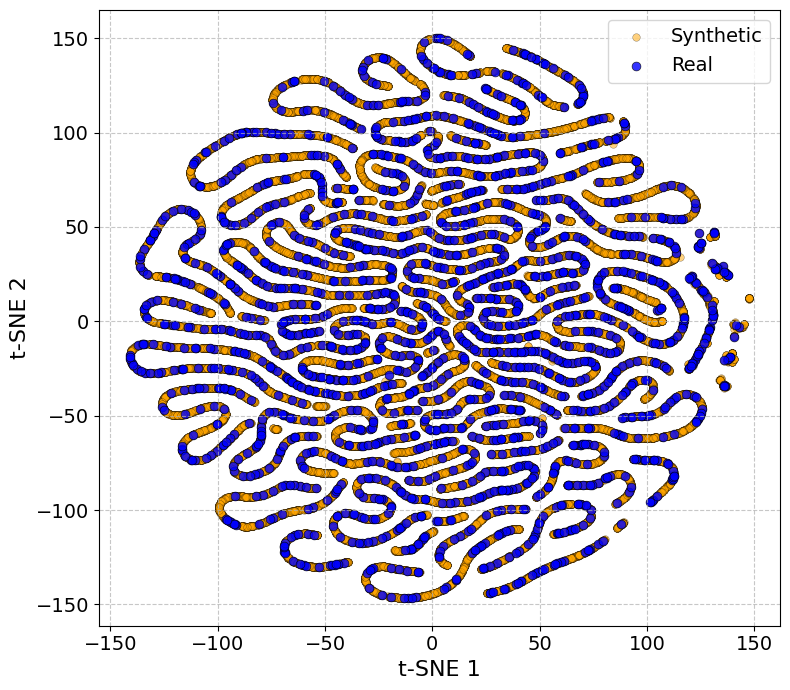

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


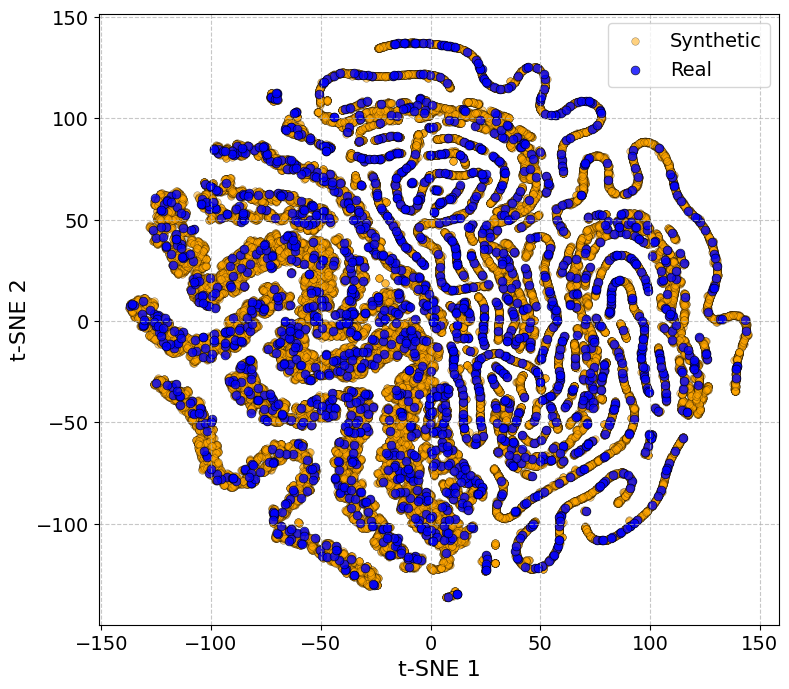

In [71]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def plot_tsne(real_scaled, synth_scaled, title):
    combined = np.vstack([real_scaled, synth_scaled])
    labels = np.array([0] * len(real_scaled) + [1] * len(synth_scaled))

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    tsne_results = tsne.fit_transform(combined)

    plt.figure(figsize=(8, 7))

    # Synthetic
    plt.scatter(tsne_results[labels == 1, 0], tsne_results[labels == 1, 1],
                c='orange', label='Synthetic', alpha=0.5, s=30,
                edgecolors='k', linewidths=0.3)

    # Real
    plt.scatter(tsne_results[labels == 0, 0], tsne_results[labels == 0, 1],
                c='blue', label='Real', alpha=0.8, s=40,
                edgecolors='k', linewidths=0.5)

    plt.legend(fontsize=14)
    plt.xlabel("t-SNE 1", fontsize=16)
    plt.ylabel("t-SNE 2", fontsize=16)
    plt.tick_params(axis='both', which='major', labelsize=14)  # Tick labels
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_tsne(X_real_botnet_scaled, X_synth_botnet_scaled, "Botnet")
plot_tsne(X_real_spam_scaled, X_synth_spam_scaled, "Spam")


One class SVM

In [72]:
from sklearn.svm import OneClassSVM


ocsvm_botnet = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')  # nu=0.05 allows ~5% outliers
ocsvm_botnet.fit(X_real_botnet_scaled)
scores_botnet = ocsvm_botnet.predict(X_synth_botnet_scaled)  # -1 for outlier, 1 for inlier

filtered_ocsvm_botnet = botnet_gen[np.array(scores_botnet) == 1]

ocsvm_spam = OneClassSVM(kernel='rbf', nu=0.05, gamma='scale')
ocsvm_spam.fit(X_real_spam_scaled)
scores_spam = ocsvm_spam.predict(X_synth_spam_scaled)

filtered_ocsvm_spam = spam_gen[np.array(scores_spam) == 1]


print("Botnet - OC-SVM accepted:", filtered_ocsvm_botnet.shape[0])
print("Spam - OC-SVM accepted:", filtered_ocsvm_spam.shape[0])


OneClassSVM(nu=0.05)

OneClassSVM(nu=0.05)

Botnet - OC-SVM accepted: 51124
Spam - OC-SVM accepted: 49766


In [73]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np


X = dforiginal.drop(columns=['Class'])
y = dforiginal['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_ocsvm_botnet = filtered_ocsvm_botnet.drop(columns='Class', errors='ignore')
filtered_ocsvm_spam = filtered_ocsvm_spam.drop(columns='Class', errors='ignore')
X_train = pd.concat([X_train_orig, filtered_ocsvm_botnet, filtered_ocsvm_spam], ignore_index=True)
y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_ocsvm_botnet)), pd.Series([4] * len(filtered_ocsvm_spam))], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_train, y_train = shuffle(X_train, y_train, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)
y_pred = mlp_classifier.predict(X_test_scaled)


class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan44', 4: 'Spam'}

print("=== MLP Classification Report (OC-SVM filtered data) ===")
y_test_class = y_test.map(class_labels)
y_pred_class = pd.Series(y_pred).map(class_labels)
print(classification_report(y_test_class, y_pred_class))

cm = confusion_matrix(y_test_class, y_pred_class)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=[class_labels[i] for i in range(len(class_labels))], columns=[class_labels[i] for i in range(len(class_labels))]))


fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_proba = mlp_classifier.predict_proba(X_test_scaled)

from sklearn.preprocessing import label_binarize
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


MLPClassifier(random_state=42)

=== MLP Classification Report (OC-SVM filtered data) ===
              precision    recall  f1-score   support

      Benign       0.99      0.84      0.91      9000
      Botnet       0.32      0.97      0.48       600
         DoS       1.00      1.00      1.00      5250
      Scan44       0.98      1.00      0.99      5250
        Spam       0.88      0.97      0.92       600

    accuracy                           0.93     20700
   macro avg       0.84      0.96      0.86     20700
weighted avg       0.97      0.93      0.94     20700


Confusion Matrix:
        Benign   DoS  Botnet  Scan44  Spam
Benign    7590  1239       7      87    77
DoS         14   583       0       3     0
Botnet       0     0    5250       0     0
Scan44       7     0       0    5243     0
Spam        18     0       0       0   582

False Negative Rate (FNR) per class:
Class Benign: 0.1567
Class DoS: 0.0283
Class Botnet: 0.0000
Class Scan44: 0.0013
Class Spam: 0.0300

False Positive Rate (FPR) per class:
C

In [74]:
filtered_ocsvm_botnet.to_csv('OCSVM_botnet_August.csv', index=False)
filtered_ocsvm_spam.to_csv('OCSVM_spam_August.csv', index=False)

k-nearest neighbors

In [75]:
from sklearn.neighbors import NearestNeighbors
import numpy as np

knn_botnet = NearestNeighbors(n_neighbors=5)
knn_botnet.fit(X_real_botnet_scaled)
distances_knn_botnet, _ = knn_botnet.kneighbors(X_synth_botnet_scaled)
avg_knn_dist_botnet = distances_knn_botnet.mean(axis=1)
threshold_knn_botnet = np.percentile(avg_knn_dist_botnet, 95)
filtered_knn_botnet = botnet_gen[np.array(avg_knn_dist_botnet) < threshold_knn_botnet]

knn_spam = NearestNeighbors(n_neighbors=5)
knn_spam.fit(X_real_spam_scaled)
distances_knn_spam, _ = knn_spam.kneighbors(X_synth_spam_scaled)
avg_knn_dist_spam = distances_knn_spam.mean(axis=1)
threshold_knn_spam = np.percentile(avg_knn_dist_spam, 95)
filtered_knn_spam = spam_gen[np.array(avg_knn_dist_spam) < threshold_knn_spam]



print("Botnet - kNN accepted:", filtered_knn_botnet.shape[0])
print("Spam - kNN accepted:", filtered_knn_spam.shape[0])


NearestNeighbors()

NearestNeighbors()

Botnet - kNN accepted: 49874
Spam - kNN accepted: 49875


In [76]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    auc
)
import numpy as np
import pandas as pd

X = dforiginal.drop(columns=['Class'])
y = dforiginal['Class'].astype(int)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_knn_botnet = filtered_knn_botnet.drop(columns='Class', errors='ignore')
filtered_knn_spam = filtered_knn_spam.drop(columns='Class', errors='ignore')

X_train = pd.concat([X_train_orig, filtered_knn_botnet, filtered_knn_spam], ignore_index=True)
y_train = pd.concat([y_train_orig,
    pd.Series([2] * len(filtered_knn_botnet)),
    pd.Series([4] * len(filtered_knn_spam)),
], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]

X_train, y_train = shuffle(X_train, y_train, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_classifier.predict(X_test_scaled)
y_proba = mlp_classifier.predict_proba(X_test_scaled)

class_labels = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

print("=== MLP Classification Report ===")
y_test_class = y_test.map(class_labels)
y_pred_class = pd.Series(y_pred_mlp).map(class_labels)
print(classification_report(y_test_class, y_pred_class))

cm = confusion_matrix(y_test_class, y_pred_class)
print("\nConfusion Matrix:")
print(pd.DataFrame(cm, index=[class_labels[i] for i in range(len(class_labels))], columns=[class_labels[i] for i in range(len(class_labels))]))

fpr_dict = {}
fnr_dict = {}

for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"Class {class_labels[k]}: {v:.4f}")

y_test_bin = label_binarize(y_test, classes=np.unique(y))
prauc_dict = {}
for i in range(len(class_labels)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[class_labels[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"Class {k}: {v:.4f}")


MLPClassifier(max_iter=300, random_state=42)

=== MLP Classification Report ===
              precision    recall  f1-score   support

      Benign       1.00      0.84      0.91      9000
      Botnet       0.33      0.97      0.49       600
         DoS       1.00      1.00      1.00      5250
        Scan       0.98      1.00      0.99      5250
        Spam       0.86      0.97      0.91       600

    accuracy                           0.93     20700
   macro avg       0.83      0.96      0.86     20700
weighted avg       0.97      0.93      0.94     20700


Confusion Matrix:
        Benign   DoS  Botnet  Scan  Spam
Benign    7598  1200       6    98    98
DoS         14   583       0     3     0
Botnet       0     0    5250     0     0
Scan         7     0       0  5243     0
Spam        16     0       0     0   584

False Negative Rate (FNR) per class:
Class Benign: 0.1558
Class DoS: 0.0283
Class Botnet: 0.0000
Class Scan: 0.0013
Class Spam: 0.0267

False Positive Rate (FPR) per class:
Class Benign: 0.0032
Class DoS: 0.0597

In [77]:
#convert to csv
filtered_knn_botnet.to_csv('knn_botnet_August.csv', index=False)
filtered_knn_spam.to_csv('knn_spam_August.csv', index=False)

Cosine similarity

Original synthetic samples botnet: 52500
After filtering: 52415
Removed samples: 85
Original synthetic samples spam: 52500
After filtering: 52390
Removed samples: 110


(array([2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        1.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 1.0000e+00, 3.0000e+00, 3.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        2.0000e+00, 5.0000e+00, 6.0000e+00, 1.0000e+00, 5.0000e+00,
        8.0000e+00, 5.0000e+00, 5.0000e+00, 9.0000e+00, 9.0000e+00,
        8.0000e+00, 4.3000e+01, 3.5000e+01, 3.9000e+01, 5.2292e+04]),
 array([0.43481482, 0.44611852, 0.45742222, 0.46872593, 0.48002963,
        0.49133333, 0.50263704, 0.51394074, 0.52524445, 0.53654815,
        0.54785185, 0.55915556, 0.57045926, 0.58176296, 0.59306667,
        0.60437037, 0.61567407, 0.62697778, 0.63828148, 0.64958519,
        0.66088889, 0.67219259, 0.6834963 , 0.

Text(0.5, 1.0, 'Cosine Similarity of Synthetic Botnet Samples')

Text(0.5, 0, 'Cosine Similarity')

Text(0, 0.5, 'Frequency')

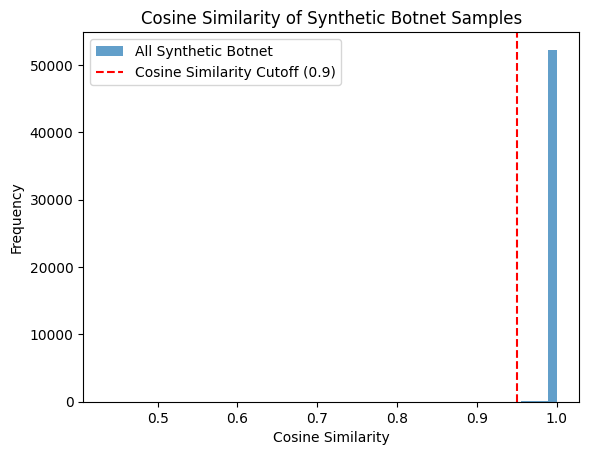

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e+00, 1.0000e+00, 1.0000e+00,
        1.0000e+00, 1.0000e+00, 4.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 3.0000e+00, 8.0000e+00, 6.0000e+00, 3.0000e+00,
        2.0000e+00, 1.0000e+00, 5.0000e+00, 3.0000e+00, 2.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 4.0000e+00,
        3.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+01, 1.3000e+01,
        1.5000e+01, 2.3000e+01, 3.9000e+01, 1.3900e+02, 5.2189e+04]),
 array([0.37697029, 0.38943088, 0.40189148, 0.41435207, 0.42681266,
        0.43927326, 0.45173385, 0.46419445, 0.47665504, 0.48911563,
        0.50157623, 0.51403682, 0.52649742, 0.53895801, 0.55141861,
        0.5638792 , 0.57633979, 0.58880039, 0.60126098, 0.61372158,
        0.62618217, 0.63864277, 0.65110336, 0.

Text(0.5, 1.0, 'Cosine Similarity of Synthetic Spam Samples')

Text(0.5, 0, 'Cosine Similarity')

Text(0, 0.5, 'Frequency')

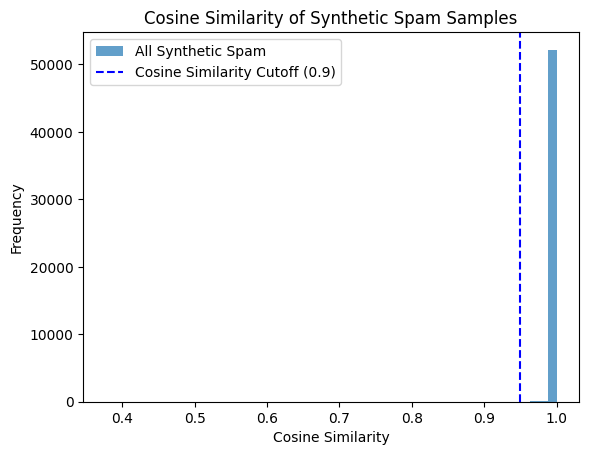

In [78]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_real_botnet_scaled = scaler.fit_transform(botnet_orig)
X_synth_botnet_scaled = scaler.transform(botnet_gen)

X_real_spam_scaled = scaler.fit_transform(spam_orig)
X_synth_spam_scaled = scaler.transform(spam_gen)

cos_sim_botnet = cosine_similarity(X_synth_botnet_scaled, X_real_botnet_scaled).max(axis=1)
cos_sim_spam = cosine_similarity(X_synth_spam_scaled, X_real_spam_scaled).max(axis=1)

threshold_botnet = 0.95
filtered_X_botnet_synth = botnet_gen[cos_sim_botnet > threshold_botnet]
threshold_spam = 0.95
filtered_X_spam_synth = spam_gen[cos_sim_spam > threshold_spam]
print("Original synthetic samples botnet:", len(X_synth_botnet_scaled))
print("After filtering:", filtered_X_botnet_synth.shape[0])
print("Removed samples:", len(X_synth_botnet_scaled) - filtered_X_botnet_synth.shape[0])

print("Original synthetic samples spam:", len(X_synth_spam_scaled))
print("After filtering:", filtered_X_spam_synth.shape[0])
print("Removed samples:", len(X_synth_spam_scaled) - filtered_X_spam_synth.shape[0])

plt.hist(cos_sim_botnet, bins=50, alpha=0.7, label='All Synthetic Botnet')
plt.axvline(threshold_botnet, color='red', linestyle='--', label='Cosine Similarity Cutoff (0.9)')
plt.title("Cosine Similarity of Synthetic Botnet Samples")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()

plt.hist(cos_sim_spam, bins=50, alpha=0.7, label='All Synthetic Spam')
plt.axvline(threshold_spam, color='blue', linestyle='--', label='Cosine Similarity Cutoff (0.9)')
plt.title("Cosine Similarity of Synthetic Spam Samples")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [79]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
import pandas as pd
import numpy as np
from sklearn.preprocessing import label_binarize

class_names = {0: 'Benign', 1: 'DoS', 2: 'Botnet', 3: 'Scan', 4: 'Spam'}

X = dforiginal.drop(columns=['Class'])
y = dforiginal['Class']

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

filtered_X_botnet_synth = filtered_X_botnet_synth.drop(columns='Class', errors='ignore')
filtered_X_spam_synth = filtered_X_spam_synth.drop(columns='Class', errors='ignore')

X_train = pd.concat([X_train_orig, filtered_X_botnet_synth], ignore_index=True)
X_train = pd.concat([X_train, filtered_X_spam_synth], ignore_index=True)


y_train = pd.concat([y_train_orig, pd.Series([2] * len(filtered_X_botnet_synth))], ignore_index=True)
y_train = pd.concat([y_train, pd.Series([4] * len(filtered_X_spam_synth))], ignore_index=True)

X_train = X_train.dropna()
y_train = y_train.loc[X_train.index]
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test = X_test[X_train.columns]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Label distribution in training set:\n", y_train.value_counts())

mlp_classifier = MLPClassifier(random_state=42)
mlp_classifier.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_classifier.predict(X_test_scaled)
print("=== MLP Classification Report ===")
print(classification_report(y_test, y_pred_mlp))

cm = confusion_matrix(y_test, y_pred_mlp)
print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm, index=[class_names[i] for i in range(len(class_names))],
                     columns=[class_names[i] for i in range(len(class_names))])
print(cm_df)
fpr_dict = {}
fnr_dict = {}
for i in range(len(cm)):
    TP = cm[i, i]
    FN = np.sum(cm[i, :]) - TP
    FP = np.sum(cm[:, i]) - TP
    TN = np.sum(cm) - TP - FP - FN

    fnr_dict[i] = FN / (FN + TP) if (FN + TP) > 0 else 0
    fpr_dict[i] = FP / (FP + TN) if (FP + TN) > 0 else 0

print("\nFalse Negative Rate (FNR) per class:")
for k, v in fnr_dict.items():
    print(f"{class_names[k]}: {v:.4f}")

print("\nFalse Positive Rate (FPR) per class:")
for k, v in fpr_dict.items():
    print(f"{class_names[k]}: {v:.4f}")

y_proba = mlp_classifier.predict_proba(X_test_scaled)

classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)

prauc_dict = {}
for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_proba[:, i])
    prauc = auc(recall, precision)
    prauc_dict[classes[i]] = prauc

print("\nPrecision-Recall AUC (PRAUC) per class:")
for k, v in prauc_dict.items():
    print(f"{class_names[k]}: {v:.4f}")


Label distribution in training set:
 2    53815
4    53790
0    21000
1    12250
3    12250
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=42)

=== MLP Classification Report ===
              precision    recall  f1-score   support

           0       1.00      0.83      0.91      9000
           1       1.00      1.00      1.00      5250
           2       0.32      0.98      0.48       600
           3       0.98      1.00      0.99      5250
           4       0.81      0.99      0.89       600

    accuracy                           0.93     20700
   macro avg       0.82      0.96      0.85     20700
weighted avg       0.97      0.93      0.94     20700


Confusion Matrix:
        Benign   DoS  Botnet  Scan  Spam
Benign    7509     5    1251    96   139
DoS          0  5250       0     0     0
Botnet      10     0     587     3     0
Scan         7     0       0  5243     0
Spam         4     0       0     0   596

False Negative Rate (FNR) per class:
Benign: 0.1657
DoS: 0.0000
Botnet: 0.0217
Scan: 0.0013
Spam: 0.0067

False Positive Rate (FPR) per class:
Benign: 0.0018
DoS: 0.0003
Botnet: 0.0622
Scan: 0.0064
Spam: 0.0069


In [80]:
filtered_X_botnet_synth.to_csv('cosine_botnet_August.csv', index=False)
filtered_X_spam_synth.to_csv('cosine_spam_August.csv', index=False)